In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as datetime
from dateutil.parser import parse

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#exploring the database
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [22]:

# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
month_12_ago = datetime.datetime.strptime(most_recent_date[0], '%Y-%m-%d')-datetime.timedelta(days=30*12)

# Perform a query to retrieve the data and precipitation scores
last_12_months = session.query(Measurement.date, Measurement.prcp)\
                 .filter(Measurement.date>=month_12_ago, Measurement.date<=most_recent_date[0])\
                 .filter(Measurement.prcp != None).all()





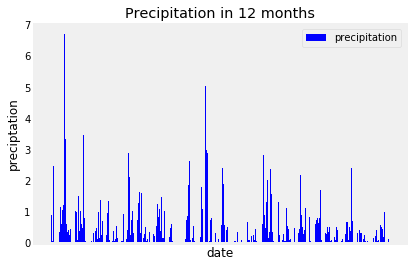

In [23]:

#unpacking the result in different list

date_value = [x[0] for x in last_12_months]
precip_value = [x[1] for x in last_12_months]

# Save the query results as a Pandas DataFrame and set the index to the date column
dt_result = pd.DataFrame({"date": date_value,
                          'precipitation':precip_value})

# # Sort the dataframe by date

dt_result.set_index("date")
dt_result.sort_values("date")
dt_result.head()

# # Use Pandas Plotting with Matplotlib to plot the data

plt.bar(dt_result["date"],dt_result["precipitation"],color='b', label = "precipitation")
plt.title("Precipitation in 12 months")
plt.xlabel("date")
plt.ylabel("preciptation")
plt.grid()
plt.legend(loc="best")
plt.tight_layout()
plt.xticks([])
plt.show()


In [24]:
# plt.savefig("./Images/precipitation.png")
# Use Pandas to calcualte the summary statistics for the precipitation data
dt_result.describe()

,precipitation
count,1985.000000
mean,0.172383
std,0.453252
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [57]:
# Design a query to show how many stations are available in this dataset?
num_station = session.query(Station).count()
print(num_station)

9


In [76]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
#most_active = engine.execute('select station, count(station) from measurement group by station order by count(station) desc')

most_active = session.query(Measurement.station, func.count(Measurement.station)).\
                            group_by(Measurement.station).\
                            order_by(func.count(Measurement.station).desc()).all()

In [77]:
for x in most_active:
    print(f'station: {x[0]} total: {x[1]}')

station: USC00519281 total: 2772
station: USC00519397 total: 2724
station: USC00513117 total: 2709
station: USC00519523 total: 2669
station: USC00516128 total: 2612
station: USC00514830 total: 2202
station: USC00511918 total: 1979
station: USC00517948 total: 1372
station: USC00518838 total: 511


In [88]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
lowest_temp= session.query(Measurement.station, func.min(Measurement.tobs)).\
                    group_by(Measurement.station).first()
highest_temp =session.query(Measurement.station, func.max(Measurement.tobs)).\
                    group_by(Measurement.station).first()
avg_temp = session.query(Measurement.station, func.avg(Measurement.tobs)).\
                    group_by(Measurement.station).first()

In [93]:
print(highest_temp[0])

USC00511918


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


In [138]:
most_recent_date = session.query(Measurement.date)\
                            .filter(Measurement.station==highest_temp[0])\
                            .order_by(Measurement.date.desc()).first()
#days = 30(days) * 12 = 1 year
month_12_ago = datetime.datetime.strptime(most_recent_date[0], '%Y-%m-%d')-datetime.timedelta(days=30*12) 

In [139]:
result_12_months = session.query(Measurement.tobs).\
                 filter(Measurement.date>=month_12_ago, Measurement.date<=most_recent_date[0]).\
                 filter(Measurement.station==highest_temp[0]).all()

(57, 80)

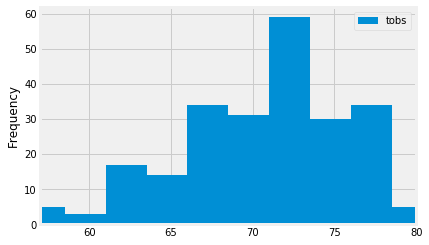

In [140]:
list_value = [x[0] for x in result_12_months]
plt.hist(list_value,bins=12, label = 'tobs')
plt.legend(loc="best")
plt.ylabel("Frequency")
plt.xlim(57,80)

# Additional Analysis

## Temperature Analysis II

In [144]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
#print(calc_temps('2012-02-28', '2012-03-05'))

In [143]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(most_recent_date[0])
print(month_12_ago.date())

print(calc_temps(str(month_12_ago.date()),str(most_recent_date[0])))

2015-10-30
2014-11-04
[(56.0, 73.33360622185837, 86.0)]


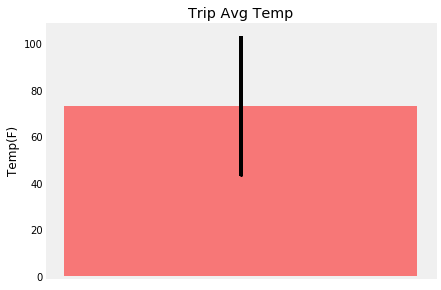

In [219]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
all_values = calc_temps(str(month_12_ago.date()),str(most_recent_date[0]))

avg_value = [x[1] for x in all_values]
min_value = [x[0] for x in all_values]
max_value = [x[2] for x in all_values]
peak_to_peak = [max_value[0]-min_value[0]]

#print(peak_to_peak)

plt.bar(1,avg_value, yerr=peak_to_peak, color='red',alpha=0.5, ecolor='black', capsize=1)
plt.tight_layout()
plt.title("Trip Avg Temp")
plt.ylabel("Temp(F)")
plt.grid()
plt.xticks([])
plt.show()